In [1]:
from Dataset import Dataset

Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
import keras.layers as L
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import *
from sklearn.model_selection import train_test_split

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

class VisualizationCallback(Callback):
    def __init__(self, on_batch=False):
        Callback.__init__(self)
        self.on_batch = on_batch
    
    def visualize(self):
        clear_output(True)
        plt.figure(figsize=[12, 4])
        
        plt.subplot(1,2,1)
        plt.title("losses")
        plt.plot(self.loss_train, label='train loss')
        plt.plot(self.loss_val, label='val loss')
        plt.grid()
        plt.legend()

        plt.subplot(1,2,2)
        plt.title("accuracy")
        plt.plot(self.val_x, self.acc_train, label='train acc')
        plt.plot(self.val_x, self.acc_val, label='val acc')
        plt.grid()
        plt.legend()
        plt.show()
    
    def on_train_begin(self, logs={}):
        self.loss_train = []
        self.acc_train = []
        self.loss_val = []
        self.acc_val = []
        self.val_x = []

    def on_batch_end(self, batch, logs={}):
        if self.on_batch:
            self.loss_val.append(logs['val_loss'])
            self.acc_val.append(logs['val_acc'])
            if batch % 100 == 0:
                self.visualize()
    
    def on_epoch_end(self, epoch, logs):
        self.loss_val.append(logs['val_loss'])
        self.acc_val.append(logs['val_acc'])
        self.val_x.append(len(self.acc_train)-1)
        if not self.on_batch:
            self.loss_train.append(logs['loss'])
            self.acc_train.append(logs['acc'])
            self.visualize()
        
        

In [11]:
# training framework for oracle net
class OracleNetTrainer(object):
    def __init__(self, test_size=0.1, autosave_path='./tmp/weights.{val_loss:.2f}.hdf5', vis_on_batch=False):
        """
        
        :param test_size: ratio of test (validation) set 
        :param autosave_path: path to auto save training results
        :param vis_on_batch: whether to record visualization on batch
        """
        # load original data
        X, y = Dataset.load_data(one_hot=False, num_cat=40)
        # normalize image to 0.0 - 1.0
        X = X / 255
        # covert to different categories
        y40 = Dataset.to_onehot(y, 40)
        y = Dataset.cat40_to_cat10(y)
        y10 = Dataset.to_onehot(y, 10)
        # train test split
        idx = list(range(y40.shape[0]))
        self.y_train = {}
        self.y_val = {}
        self.X_train, self.X_val, y_train_idx, y_val_idx = train_test_split(X, idx, test_size=test_size, shuffle=True)
        self.y_train[40], self.y_val[40] = y40[y_train_idx], y40[y_val_idx]
        self.y_train[10], self.y_val[10] = y10[y_train_idx], y10[y_val_idx]
        # initialize callbacks
        self.checkpointer = ModelCheckpoint(filepath=autosave_path, verbose=1, save_best_only=True)
        self.visualizer = VisualizationCallback(vis_on_batch)

    def train(self, model, num_cat=10, batch_size=32, epochs=50):
        assert num_cat in [10, 40], "Number of categories can only be 10 or 40"
        model.fit(self.X_train, self.y_train[num_cat], batch_size=batch_size, epochs=epochs,
                  validation_data=(self.X_val, self.y_val[num_cat]),
                  callbacks=[self.visualizer, self.checkpointer])

default_trainer = OracleNetTrainer()

### Simple Cat10

In [12]:
def cat10_model_simple():
    model = Sequential()
    
#     model.add(L.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
#     model.add(L.Conv2D(32, (3, 3), activation='relu'))
#     model.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     model.add(L.Dropout(0.25))

#     model.add(L.Conv2D(64, (3, 3), activation='relu'))
#     model.add(L.Conv2D(64, (3, 3), activation='relu'))
#     model.add(L.MaxPooling2D(pool_size=(2, 2)))
#     model.add(L.Dropout(0.25))
    
    model.add(L.Flatten(input_shape=(64,64,1)))
#     model.add(L.Flatten())
    model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(10, activation='softmax'))
    
    return model

In [13]:
model = cat10_model_simple()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 267,018
Trainable params: 267,018
Non-trainable params: 0
_________________________________________________________________


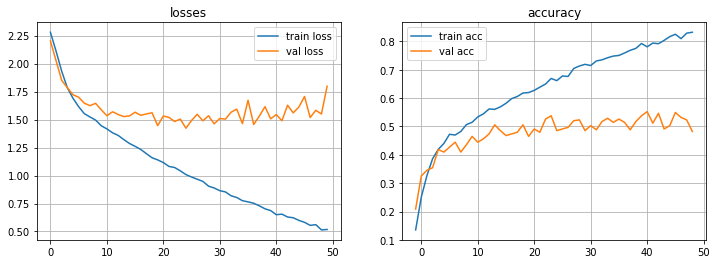


Epoch 00050: val_loss did not improve from 1.42270


In [14]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])

default_trainer.train(model)

In [ ]:
model.evaluate(X_val, y_val)